# Alcohol Abuse Effects on EEG Data
## Neural Data Science Final Project

### Will Kersh​
### Dylan Cullifer​
### Isabell Cook

# Imports and Sample Data

In [7]:
import pandas as pd
import numpy as np
import mne
import mne.viz
from mne.viz import plot_topomap
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.channels import make_standard_montage
import scipy as sp
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib
import copy
from scipy.signal import hilbert
import os
from tqdm import tqdm

# one alcoholic patient and one control with same condition
alc_1 = pd.read_csv("eeg+database/SMNI_CMI_TRAIN/Data1.csv")
control_236 = pd.read_csv("eeg+database/SMNI_CMI_TRAIN/Data236.csv")

alc_1.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,6,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,7,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,8,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,9,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


# Load data
This code enumerates over all of the training data files to load them in to our EEG_data object

In [ ]:
file_names = [f for f in os.listdir('eeg+database/SMNI_CMI_TRAIN/') if f.endswith('.csv')]
EEG_data = pd.DataFrame({}) # create an empty data frame that will hold data from each file

for file_name in tqdm(file_names):
    temp_df = pd.read_csv('eeg+database/SMNI_CMI_TRAIN/' + file_name) # used to read each file into EEG_data
    EEG_data = pd.concat([EEG_data, temp_df], ignore_index=True)      # add the file data to the main data frame
    
EEG_data = EEG_data.drop(['Unnamed: 0'], axis=1)                      # remove the unused column
EEG_data.loc[EEG_data['matching condition'] == 'S2 nomatch,', 'matching condition'] = 'S2 nomatch' # remove comma from stimulus name

print(f"Loaded {len(file_names)} files")
print(f"Total rows: {len(EEG_data)}")
EEG_data.head()

100%|██████████| 468/468 [00:48<00:00,  9.63it/s]



Loaded 468 files
Total rows: 7667712


,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,0,FP1,0,-8.921,a,S1 obj,0,co2a0000364,0.000000
1,0,FP1,1,-8.433,a,S1 obj,0,co2a0000364,0.003906
2,0,FP1,2,-2.574,a,S1 obj,0,co2a0000364,0.007812
3,0,FP1,3,5.239,a,S1 obj,0,co2a0000364,0.011719
4,0,FP1,4,11.587,a,S1 obj,0,co2a0000364,0.015625


In [9]:
control_236.head()

,Unnamed: 0,trial number,sensor position,sample num,sensor value,subject identifier,matching condition,channel,name,time
0,5,0,FP1,0,3.082,c,S1 obj,0,co2c0000337,0.000000
1,6,0,FP1,1,2.594,c,S1 obj,0,co2c0000337,0.003906
2,7,0,FP1,2,2.106,c,S1 obj,0,co2c0000337,0.007812
3,8,0,FP1,3,2.106,c,S1 obj,0,co2c0000337,0.011719
4,9,0,FP1,4,3.571,c,S1 obj,0,co2c0000337,0.015625


### Some Pre-processing

In [ ]:
## replace some 'sensor position' values
EEG_data.loc[EEG_data['sensor position'] == 'AF1', 'sensor position'] = 'AF3'
EEG_data.loc[EEG_data['sensor position'] == 'AF2', 'sensor position'] = 'AF4'
EEG_data.loc[EEG_data['sensor position'] == 'PO1', 'sensor position'] = 'PO3'
EEG_data.loc[EEG_data['sensor position'] == 'PO2', 'sensor position'] = 'PO4'

Creating RawArray with float64 data, n_channels=61, n_times=256
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
    Range : 0 ... 255 =      0.000 ...     0.996 secs
Ready.
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).
Effective window size : 1.000 (s)
Plotting power spectral density (dB=True).


c:\Users\Will\miniforge3\Lib\site-packages\mne\viz\utils.py:158: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  (fig or plt).show(**kwargs)


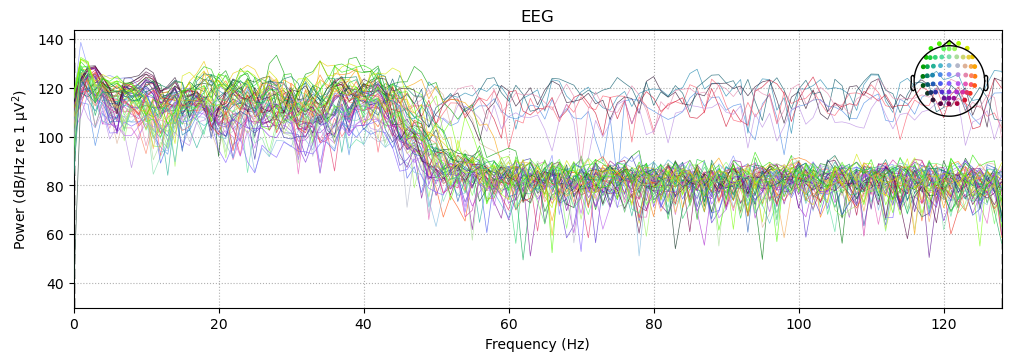

In [10]:

def csv_to_eeg_data(csv_file):
    data = pd.read_csv(csv_file)
    # I have no idea what these placements are and error if you leave them
    data = data.drop(data[data["sensor position"].isin(["X", "Y", "nd"])].index)

    # sensor placement names error out unless you fix them
    data["sensor position"] = data["sensor position"].replace({'FP1': 'Fp1', 'FP2': 'Fp2',
                                                               'FZ': 'Fz', 'CZ': 'Cz',
                                                               'PZ': 'Pz', 'FPZ': 'Fpz',
                                                               'AFZ': 'AFz', 'FCZ': 'FCz',
                                                               'POZ': 'POz', 'OZ': 'Oz',
                                                               'CPZ': 'CPz'})

    # get pos names
    sensor_pos = list(data["sensor position"].unique())
    # extract only needed eeg data
    subset = data[["channel", "sensor value", "sample num"]]
    # flip into channels x time 
    formatted = subset.pivot(index="channel", columns="sample num", values="sensor value").sort_index(axis=1)
    new_data = formatted.to_numpy()

    # convert to mne data and set channels
    channels_sfreq = mne.create_info(ch_names=sensor_pos, sfreq=256, ch_types="eeg")
    mne_data = mne.io.RawArray(new_data, channels_sfreq)

    mne_data.set_montage(mne.channels.make_standard_montage('standard_1020'))

    return mne_data


alc_test = csv_to_eeg_data("eeg+database/SMNI_CMI_TRAIN/Data1.csv")
alc_test.plot_psd()